In [1]:
import anndata as ad
import torch
import pandas as pd
import requests
import sys
import os
import scanpy as sc
#import pertpy as pt      # comment-out when using nen_env
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pickle
from scipy.stats import wasserstein_distance, permutation_test
from scipy.spatial.distance import cdist, pdist, squareform

from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')

import utils            # comment-out when using pertpy_env

In [2]:
df_expr_ref_celline = pd.read_csv('../data/expression_reference/rna_celline.tsv', sep='\t')
df_expr_ref_cell_type = pd.read_csv('../data/expression_reference/rna_single_cell_type.tsv', sep='\t')

In [3]:
df_expr_ref_cell_type

,Gene,Gene name,Cell type,nTPM
0,ENSG00000000003,TSPAN6,Adipocytes,147.5
1,ENSG00000000003,TSPAN6,Alveolar cells type 1,6.0
2,ENSG00000000003,TSPAN6,Alveolar cells type 2,10.9
3,ENSG00000000003,TSPAN6,Astrocytes,13.6
4,ENSG00000000003,TSPAN6,B-cells,1.5
...,...,...,...,...
1626637,ENSG00000288695,ENSG00000288695,Squamous epithelial cells,0.1
1626638,ENSG00000288695,ENSG00000288695,Suprabasal keratinocytes,0.3
1626639,ENSG00000288695,ENSG00000288695,Syncytiotrophoblasts,0.0
1626640,ENSG00000288695,ENSG00000288695,T-cells,0.1


In [6]:
df_expr_ref = pd.DataFrame(columns = ['Cell Line', 'Gene'])

k562 = {'Cell Line': 'K562', 'Gene': list(df_expr_ref_celline[(df_expr_ref_celline['Cell line'] == 'K-562') & (df_expr_ref_celline['TPM'] > 0.0)]['Gene'].unique())}
df_expr_ref = pd.concat([df_expr_ref, pd.DataFrame(k562)])
melanocytes = {'Cell Line': 'melanocytes', 'Gene': list(df_expr_ref_cell_type[(df_expr_ref_cell_type['Cell type'] == 'Melanocytes') & (df_expr_ref_cell_type['nTPM'] > 0.0)]['Gene'].unique())}
df_expr_ref = pd.concat([df_expr_ref, pd.DataFrame(melanocytes)])
neurons = {'Cell Line': 'iPSC-induced neuron', 'Gene': list(df_expr_ref_cell_type[((df_expr_ref_cell_type['Cell type'] == 'Excitatory neurons') | (df_expr_ref_cell_type['Cell type'] == 'Inhibitory neurons')) & (df_expr_ref_cell_type['nTPM'] > 0.0)]['Gene'].unique())}
df_expr_ref = pd.concat([df_expr_ref, pd.DataFrame(neurons)])
hTERT_RPE1 = {'Cell Line': 'RPE1', 'Gene': list(df_expr_ref_celline[(df_expr_ref_celline['Cell line'] == 'hTERT-RPE1') & (df_expr_ref_celline['TPM'] > 0.0)]['Gene'].unique())}
df_expr_ref = pd.concat([df_expr_ref, pd.DataFrame(hTERT_RPE1)])
Undifferentiated_cells = {'Cell Line': 'iPSC', 'Gene': list(df_expr_ref_cell_type[(df_expr_ref_cell_type['Cell type'] == 'Undifferentiated cells') & (df_expr_ref_cell_type['nTPM'] > 0.0)]['Gene'].unique())}
df_expr_ref = pd.concat([df_expr_ref, pd.DataFrame(Undifferentiated_cells)])

df_expr_ref

,Cell Line,Gene
0,K562,ENSG00000000003
1,K562,ENSG00000000419
2,K562,ENSG00000000457
3,K562,ENSG00000000460
4,K562,ENSG00000000938
...,...,...
14969,iPSC,ENSG00000286522
14970,iPSC,ENSG00000287080
14971,iPSC,ENSG00000288558
14972,iPSC,ENSG00000288637


In [7]:
df_expr_ref['Cell Line'].unique()

array(['K562', 'melanocytes', 'iPSC-induced neuron', 'RPE1', 'iPSC'],
      dtype=object)

In [8]:
df_expr_ref['Gene'].value_counts()

Gene
ENSG00000285437    5
ENSG00000285053    5
ENSG00000003249    5
ENSG00000003147    5
ENSG00000003137    5
                  ..
ENSG00000213171    1
ENSG00000212722    1
ENSG00000211812    1
ENSG00000211689    1
ENSG00000204978    1
Name: count, Length: 18436, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

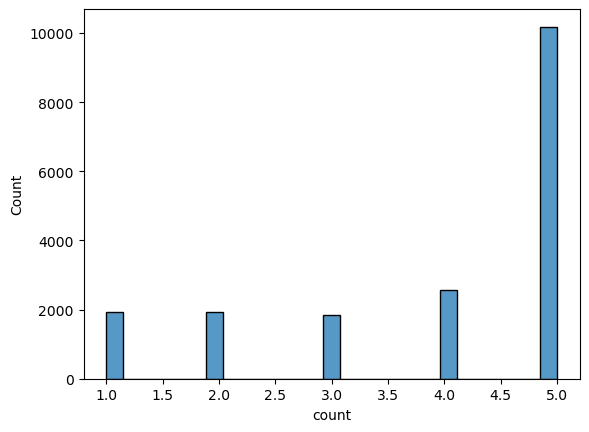

In [9]:
sns.histplot(df_expr_ref['Gene'].value_counts())

In [10]:
df_expr_ref.to_csv('../data/expression_reference/expression_reference.csv')